In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import cv2
import itertools
from keras.models import load_model

Using TensorFlow backend.


In [2]:
import numpy as np
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt

#import keras_metrics
from imgaug import augmenters as iaa
import tensorflow as tf
#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

np.random.seed(1)

In [3]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def matthews_correlation(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [20]:
x_train = np.load("datasets/normal/x_train_200.npy")
y_train = np.load("datasets/normal/y_train_200.npy")
x_train.shape, y_train.shape

((22046, 200, 200, 3), (22046, 2))

In [15]:
x_val = np.load("datasets/normal/x_val_200.npy")
y_val = np.load("datasets/normal/y_val_200.npy")
x_val.shape, y_val.shape

((2756, 200, 200, 3), (2756, 2))

In [4]:
x_test = np.load("datasets/normal/x_test_200.npy")
y_test = np.load("datasets/normal/y_test_200.npy")
x_test.shape, y_test.shape

((2756, 200, 200, 3), (2756, 2))

In [5]:
model = None
model = load_model("vgg_sterioid.h5", custom_objects={'auc':auc, 'precision':precision, 'f1':f1, 'recall':recall, 'matthews_correlation': matthews_correlation})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [6]:
x_test.shape, y_test.shape

((2756, 200, 200, 3), (2756, 2))

In [7]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2756/2756 [==============================] - 17s 6ms/step
Test loss: 0.021791184063610036
Test accuracy: 0.9912917271407837


In [6]:
def tensor_3to4(img):
    '''
    Resizes and expands dimension
    
    Input: img: a 3-channel image as input
    
    Returns a rank-4 tensor, since the network accepts batches of images
    One image corresponds to batch size of 1
    '''
    img = cv2.resize(img, (200, 200))
    img_4d = np.expand_dims(img, axis=0)  # rank 4 tensor for prediction
    return img_4d

In [7]:
def inference(img):
    '''Accepts a single input image of rank-4 and makes predictions and 
    returns the predicted label
    '''
    res = ""
    #import pdb; pdb.set_trace()
    img = tensor_3to4(img)
    y_pred = model.predict(img)
    print(y_pred)
    y = np.argmax(y_pred)
    print(y)
    
    if y == 1:
        res = "Parasite!"
    else:
        res = "Not parasite"
    return res

In [8]:
y_preds = model.predict(x_test, verbose=1)
y_preds.shape

2756/2756 [==============================] - 17s 6ms/step


(2756, 2)

In [9]:
y_preds = np.load("y_pred_vgg_sterioid.npy")
y_preds.shape

(2756, 2)

In [10]:
y_test.shape, y_preds.shape

((2756, 2), (2756, 2))

In [11]:
y_pred_flat = np.argmax(y_preds, axis=1)
y_test_flat = np.argmax(y_test, axis=1)
y_pred_flat.shape, y_test_flat.shape

((2756,), (2756,))

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true = y_test_flat, y_pred = y_pred_flat)
print(cm)

[[1375   34]
 [  29 1318]]


In [15]:
accuracy = np.mean((y_test_flat==y_pred_flat))
accuracy

0.9771407837445574

In [17]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

target_names = ['0', '1']

def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1375   34]
 [  29 1318]]


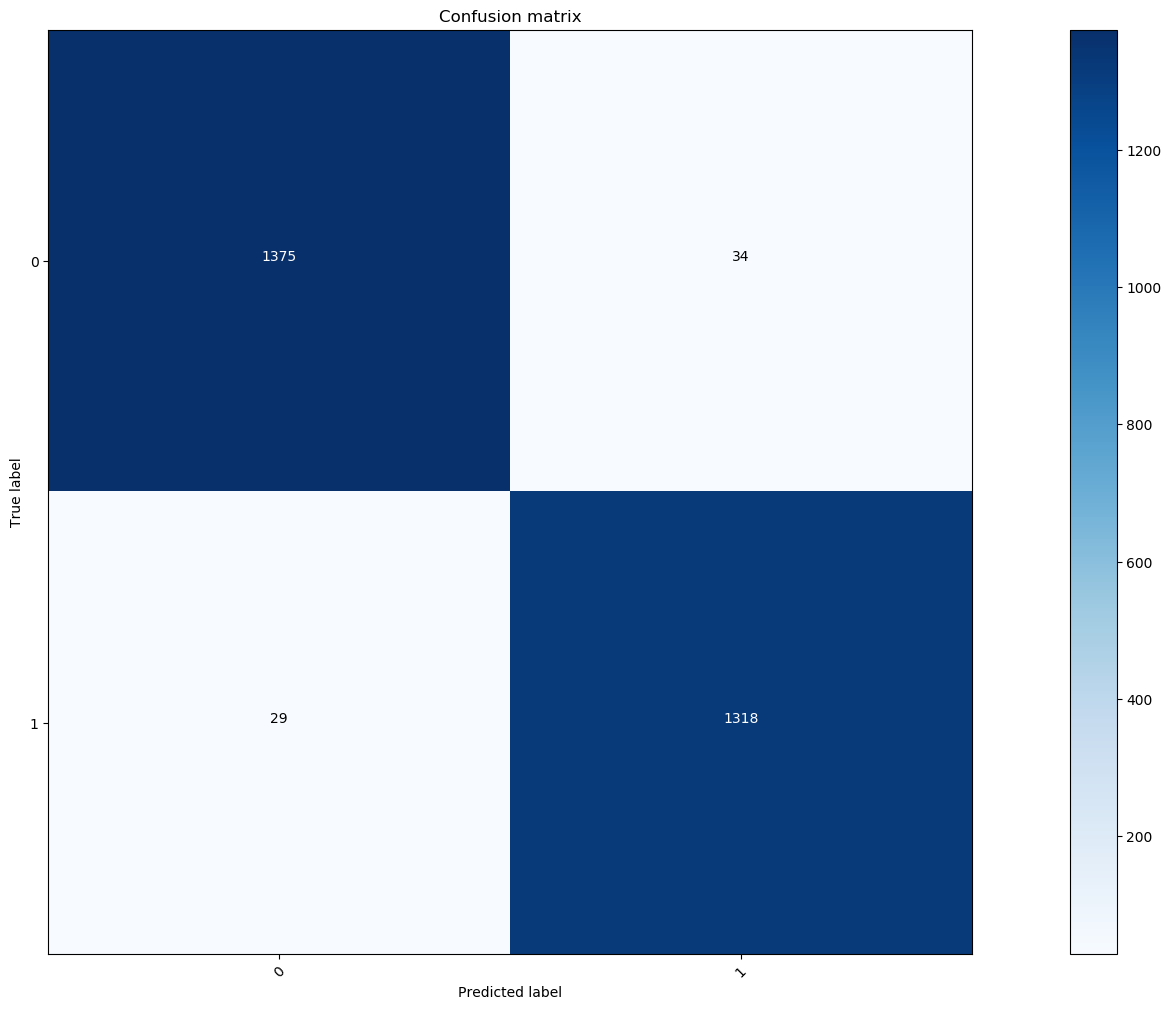

In [18]:
plt.figure(figsize=(20,10), dpi=100)
plot_confusion_matrix(cm, classes=target_names,
                  title='Confusion matrix')
plt.show()